In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
sns.set_theme(style = 'darkgrid')
pd.set_option('display.max_columns', None)

In [68]:
complaints_path = 'data/allegations_202007271729.csv'
layout_path = 'data/CCRB Data Layout Table.xlsx'
excelList = pd.ExcelFile(layout_path).sheet_names
excelList

['Layout', 'Rank Abbrevs', 'Command Abbrevs', 'FADO', 'Dispositions']

In [69]:
layout = pd.read_excel(layout_path)
police_abbrev = pd.read_excel(layout_path, sheet_name=excelList[1])
complaints = pd.read_csv(complaints_path)
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,078 PCT,POM,POM,Police Officer,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,PBBS,POM,POM,Police Officer,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,078 PCT,POF,POF,Police Officer,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [70]:
layout.drop(columns = "glossary")

,field name,description
0,unique_mos_id,"unique ID of the officer (""member of service"")"
1,first_name,Officer's first name
2,last_name,Officer's last name
3,command_now,Officer's command assignment as of July 2020
4,complaint_id,Unique ID of the complaint
5,month_received,Month the complaint was received by CCRB
6,year_received,Year the complaint was received by CCRB
7,month_closed,Month the complaint investigation was closed b...
8,year_closed,Year the complaint investigation was closed by...
9,command_at_incident,Officer's command assignment at the time of th...


In [71]:
complaint_times = complaints[['month_received', 'year_received', 'month_closed', 'year_closed']]
display(complaint_times)
complaint_times.info()

,month_received,year_received,month_closed,year_closed
0,7,2019,5,2020
1,11,2011,8,2012
2,11,2011,8,2012
3,7,2012,9,2013
4,8,2018,2,2019
...,...,...,...,...
33353,8,2016,2,2017
33354,8,2016,2,2017
33355,8,2016,2,2017
33356,8,2016,2,2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   month_received  33358 non-null  int64
 1   year_received   33358 non-null  int64
 2   month_closed    33358 non-null  int64
 3   year_closed     33358 non-null  int64
dtypes: int64(4)
memory usage: 1.0 MB


In [72]:
time_labels = [('month_received', 'year_received'), ('month_closed', 'year_closed')]
times = []

for label in time_labels:
    times += [pd.to_datetime(complaint_times[label[0]].apply(lambda month: "0" + str(month) if len(str(month)) == 1 else str(month)) + "/" + complaint_times[label[1]].astype(str), format="%m/%Y")]

complaints = complaints.assign(date_received = times[0]).assign(date_closed = times[1]).drop(columns = complaint_times.columns)

In [73]:
complaints['days_taken'] = (complaints['date_closed'] - complaints['date_received']).dt.days
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,date_received,date_closed,days_taken
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,078 PCT,POM,POM,Police Officer,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,305
1,10007,John,Sears,078 PCT,5952,24601,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274
2,10007,John,Sears,078 PCT,5952,24601,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274
3,10007,John,Sears,078 PCT,5952,26146,PBBS,POM,POM,Police Officer,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01,427
4,10009,Noemi,Sierra,078 PCT,24058,40253,078 PCT,POF,POF,Police Officer,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),2018-08-01,2019-02-01,184


In [74]:
complaints['days_taken'].describe()

count    33358.000000
mean       296.268721
std        152.703275
min          0.000000
25%        183.000000
50%        303.000000
75%        396.000000
max       3348.000000
Name: days_taken, dtype: float64

<AxesSubplot:xlabel='days_taken', ylabel='complainant_age_incident'>

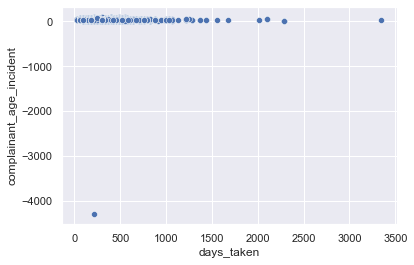

In [75]:
sns.scatterplot(data = complaints, x = complaints['days_taken'], y = 'complainant_age_incident')

In [76]:
complaints[['complainant_age_incident', 'mos_age_incident']].describe()

,complainant_age_incident,mos_age_incident
count,28546.000000,33358.000000
mean,32.484201,32.346873
std,28.408963,6.040944
min,-4301.000000,20.000000
25%,23.000000,28.000000
50%,30.000000,31.000000
75%,41.000000,36.000000
max,101.000000,60.000000


In [77]:
complaints[complaints['complainant_age_incident'] <= 0] = np.nan
complaints['complainant_age_incident'].min()

1.0

Correlation between duration of complaint and age of complainant: -0.08829041205291156


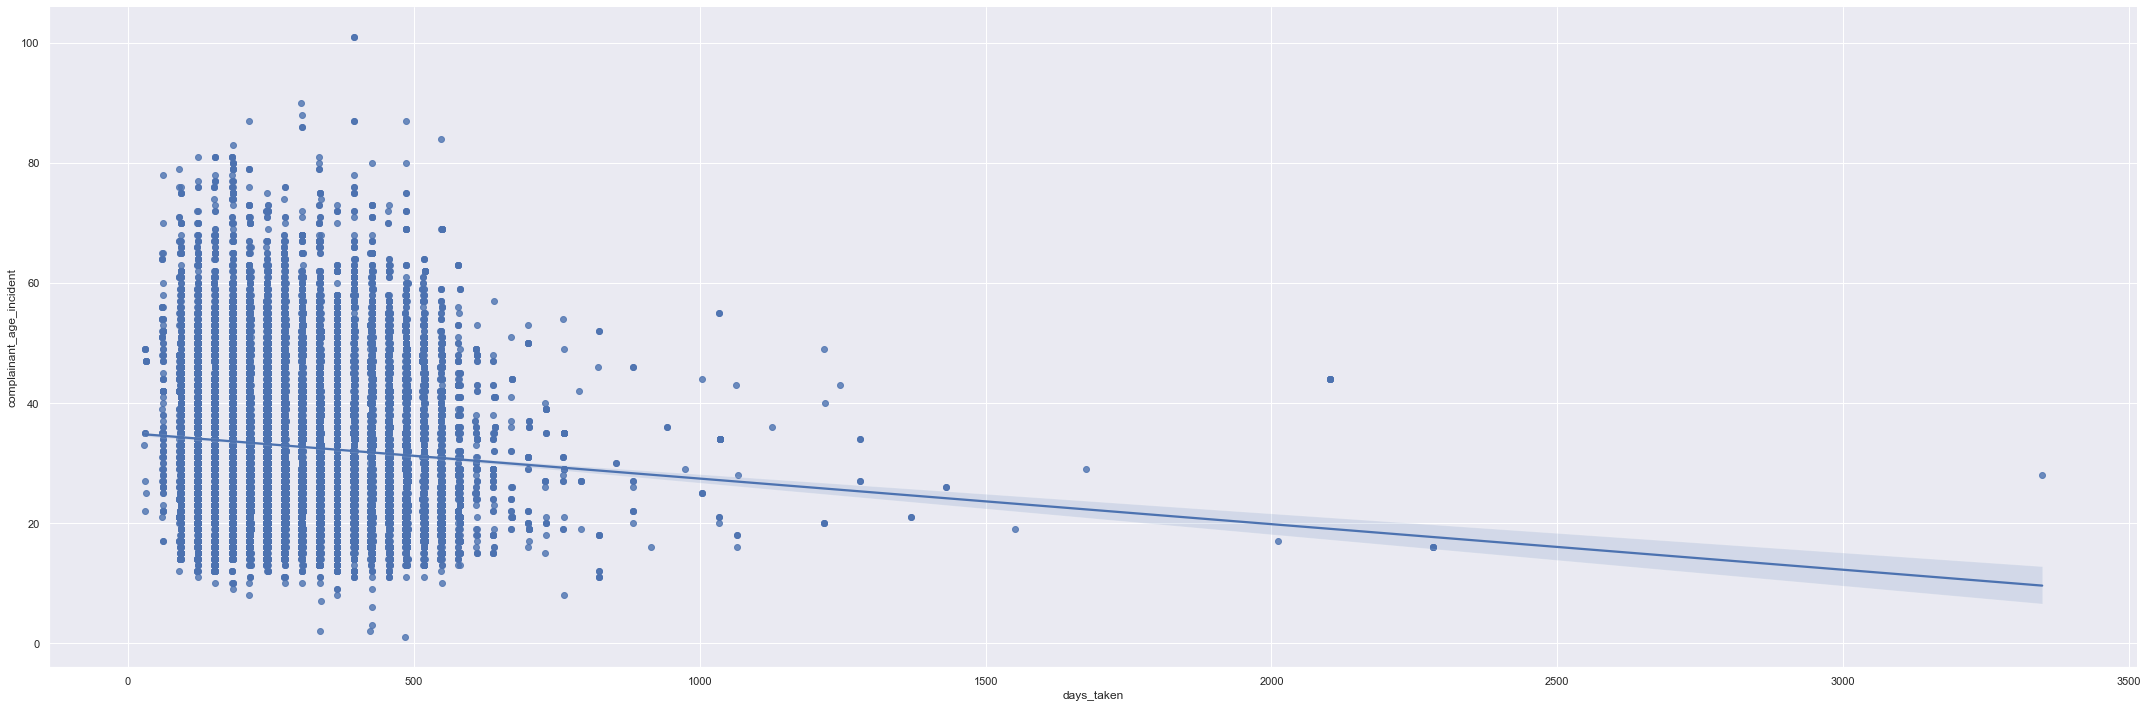

In [78]:
sns.lmplot(data = complaints, x = "days_taken", y = 'complainant_age_incident', height = 10, aspect = 3)
print("Correlation between duration of complaint and age of complainant: {}".format(complaints.corr().loc['days_taken', 'complainant_age_incident']))

### Now, let's clean up the qualitative columns by detailing a course of action for each qualitative column:

In [79]:
complaints.nunique()

unique_mos_id                3996
first_name                   1217
last_name                    2835
command_now                   415
shield_no                    3334
complaint_id                12052
command_at_incident           361
rank_abbrev_incident           18
rank_abbrev_now                20
rank_now                        8
rank_incident                   8
mos_ethnicity                   5
mos_gender                      2
mos_age_incident               40
complainant_ethnicity           8
complainant_gender              6
complainant_age_incident       86
fado_type                       4
allegation                    115
precinct                       79
contact_reason                 53
outcome_description            23
board_disposition              11
date_received                 390
date_closed                   385
days_taken                    132
dtype: int64

- unique_mos_id, first_name, last_name, command_now, shield_no, complaint_id, contact_reason, allegation, and command_at_incident all contain hundreds if not thousands of unique values that, for simplicity's sake, will be left alone
- rank_abbrev_incident and rank_abbrev_now have more unique values than rank_now and rank_incident so we can convert these abbreviations to achieve higher granularity in our dataset
- mos_ethnicity, mos_gender, complainant_ethnicity, complainant_gender, fado_type, board_disposition, precinct, and outcome_description can be manually checked for inconsistencies and cleaned accordingly due to their limited diversity

Let's first start with enhancing granularity by converting abbreviations into full ranks. We can achieve this by joining `police_abbrev` with our original dataset.

In [80]:
display(police_abbrev.head())

,Abbreviation,Rank
0,POM,Police Officer
1,POF,Police Officer
2,PO,Police Officer
3,PSA,Police Officer Special Assignment
4,SGT,Sergeant


In [81]:
def convert_abbrev(police_abbrev, complaints):
    merged = complaints.merge(police_abbrev, how='inner', left_on=['rank_abbrev_incident'], right_on =['Abbreviation']).merge(police_abbrev, how = 'inner', left_on=['rank_abbrev_now'], right_on=['Abbreviation'], suffixes=("_incident", "_now")).drop(columns = ['rank_abbrev_incident', 'rank_abbrev_now', 'rank_now', 'rank_incident', 'Abbreviation_incident', 'Abbreviation_now'])
    return merged

merged_complaints = convert_abbrev(police_abbrev, complaints)
merged_complaints[['Rank_incident', 'Rank_now']].nunique()

Rank_incident    15
Rank_now         18
dtype: int64

Now, let's manually sift through features that have a low amount of unique values and look for inconsistencies.

In [82]:
small_qualitative_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'board_disposition', 'precinct', 'outcome_description']
for feature in small_qualitative_features:
    print("{}'s unique values are: {}".format(feature, merged_complaints[feature].unique()), end='\n\n')

mos_ethnicity's unique values are: ['Hispanic' 'White' 'Asian' 'Black' 'American Indian']

mos_gender's unique values are: ['M' 'F']

complainant_ethnicity's unique values are: ['Black' 'White' 'Asian' 'Refused' 'Hispanic' 'Other Race' nan 'Unknown'
 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Not described' 'Transwoman (MTF)'
 'Gender non-conforming']

fado_type's unique values are: ['Abuse of Authority' 'Discourtesy' 'Offensive Language' 'Force']

board_disposition's unique values are: ['Substantiated (Command Lvl Instructions)' 'Substantiated (Charges)'
 'Substantiated (Formalized Training)' 'Unsubstantiated'
 'Substantiated (Command Discipline A)' 'Exonerated'
 'Substantiated (Command Discipline B)'
 'Substantiated (Command Discipline)' 'Substantiated (Instructions)'
 'Substantiated (No Recommendations)' 'Substantiated (MOS Unidentified)']

precinct's unique values are: [  78.   67.   10.   79.   90.   46.    9.   28.  120.   6

- complainant_ethnicity and complainant_gender have vague values that should be represented with `np.nan`
- New York contains precincts between 1 and 123, and so any precincts outside of that range should be represented with `np.nan`

In [83]:
def replace_with_nan(complaints):
    columns_to_clean = ['complainant_ethnicity', 'complainant_gender', 'precinct']
    replaced_with_nan = complaints.assign(complainant_ethnicity = complaints['complainant_ethnicity'].replace({"Refused": np.nan, 'Unknown': np.nan, 'Other Race': np.nan})).assign(complainant_gender = complaints['complainant_gender'].replace({'Not described': np.nan}))
    replaced_with_nan[(replaced_with_nan['precinct'] > 123) | (replaced_with_nan['precinct'] <= 0)] = np.nan
    for column in columns_to_clean:
        print("{}'s unique values are: {}".format(column, replaced_with_nan[column].unique()), end='\n\n')
    return replaced_with_nan

cleaned_nan = replace_with_nan(merged_complaints)

complainant_ethnicity's unique values are: ['Black' 'White' 'Asian' nan 'Hispanic' 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Transwoman (MTF)'
 'Gender non-conforming']

precinct's unique values are: [ 78.  67.  10.  79.  90.  46.   9.  28. 120.  68.  70.  72. 122. 100.
   1.   7.  81.  63.  52.  47.  83.  42.  84.  73.  13.   5.  88.  77.
  75.  94.  40.  18.  69. 101. 110. 103. 102.  62.  25. 104. 105. 106.
 113.  17.  34. 107. 108. 109. 115.  19. 112.  43. 111.  32.  71.  14.
  60. 114.  26.  20.  61.   6.  48. 121.  66. 123.  30.  41.  50.  49.
  44.  45.  23.  22.  nan  33.  24.  76.]



Let's also drop unique_mos_id because shield_no already satisfies the need for a unique identifier.

In [84]:
columns_to_drop = ['unique_mos_id']
cleaned = cleaned_nan.drop(columns = columns_to_drop)
cleaned.head()

,first_name,last_name,command_now,shield_no,complaint_id,command_at_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,date_received,date_closed,days_taken,Rank_incident,Rank_now
0,Jonathan,Ruiz,078 PCT,8409.0,42835.0,078 PCT,Hispanic,M,32.0,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,305.0,Police Officer,Police Officer
1,John,Sears,078 PCT,5952.0,24601.0,PBBS,White,M,24.0,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274.0,Police Officer,Police Officer
2,John,Sears,078 PCT,5952.0,24601.0,PBBS,White,M,24.0,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274.0,Police Officer,Police Officer
3,John,Sears,078 PCT,5952.0,26146.0,PBBS,White,M,25.0,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01,427.0,Police Officer,Police Officer
4,Malachy,Sullivan,078 PCT,4143.0,33969.0,078 PCT,White,M,43.0,White,Male,34.0,Offensive Language,Sexual orientation,78.0,PD suspected C/V of violation/crime - street,Summons - other violation/crime,Substantiated (Formalized Training),2015-11-01,2016-02-01,92.0,Police Officer,Police Officer


### Time for explatory data analysis:

Let's begin with plotting age distributions of both police officers and complainants. We ultimately would like to perform a permutation test to see if there is an observable difference in age between police officers and complainants.

<AxesSubplot:ylabel='Frequency'>

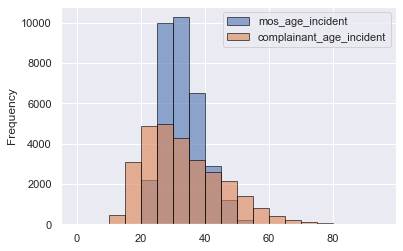

In [85]:
ages = ['mos_age_incident', 'complainant_age_incident']
cleaned[ages].plot.hist(bins=range(0, 100, 5), ec = 'black', alpha = 0.6)

In [86]:
display(cleaned[ages].mean())
display(cleaned[ages].count())

mos_age_incident            32.348829
complainant_age_incident    32.642592
dtype: float64

mos_age_incident            33257
complainant_age_incident    28522
dtype: int64

We see an issue here. There are far more police officer entries than there are complainants, and so a distribution would not the best way to capture any differences. Let's reshape our data to where we get the categorical distribution of age group proportions. Let's group ages by intervals of 5, which shouldn't filter out too much granularity.

In [87]:
def assign_age_groups(cleaned):
    age_df = pd.DataFrame()
    def round_to_five(age):
        tenths, ones = age//10, age % 10
        if ones >= 0 and ones < 5:
            ones = 0
        else:
            ones = 5
        return str((tenths * 10) + ones) + "-" + str((tenths * 10) + ones + 4)
    age_df['officer_age_group'] = cleaned['mos_age_incident'].apply(round_to_five)
    age_df['complainant_age_group'] = cleaned['complainant_age_incident'].apply(round_to_five)
    return pd.concat([age_df, cleaned[ages]], axis = 1).replace({"nan-nan": np.nan})
age_df = assign_age_groups(cleaned)
age_df.head()

,officer_age_group,complainant_age_group,mos_age_incident,complainant_age_incident
0,30.0-34.0,35.0-39.0,32.0,38.0
1,20.0-24.0,25.0-29.0,24.0,26.0
2,20.0-24.0,25.0-29.0,24.0,26.0
3,25.0-29.0,45.0-49.0,25.0,45.0
4,40.0-44.0,30.0-34.0,43.0,34.0


In [88]:
complainant_age_group = age_df.groupby("complainant_age_group")['complainant_age_incident'].count()/age_df.groupby("complainant_age_group")['complainant_age_incident'].count().sum(axis = 0)
officer_age_group = age_df.groupby("officer_age_group")['mos_age_incident'].count()/age_df.groupby("officer_age_group")['mos_age_incident'].count().sum(axis = 0)

In [89]:
age_probabilities = pd.concat([officer_age_group, complainant_age_group], axis = 1).fillna(0)
age_probabilities.index.name = 'age_group'
age_probabilities

,mos_age_incident,complainant_age_incident
age_group,,
20.0-24.0,0.066272,0.171131
25.0-29.0,0.300418,0.174637
30.0-34.0,0.308567,0.149113
35.0-39.0,0.195838,0.110897
40.0-44.0,0.086328,0.090316
45.0-49.0,0.035481,0.074399
50.0-54.0,0.006465,0.049681
55.0-59.0,0.000631,0.027523
0.0-4.0,0.000000,0.000140


Text(0.5, 1.0, 'Probability distributions of age groups')

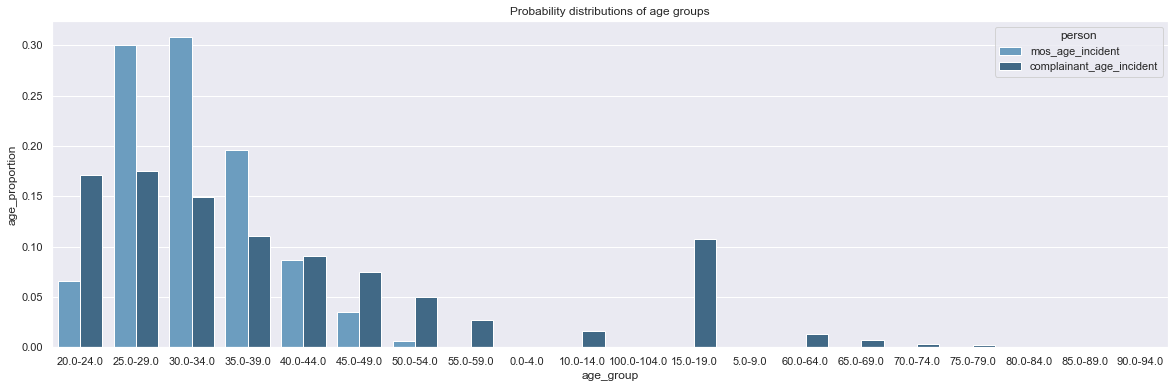

In [99]:
fig, ax = plt.subplots(figsize=(20,6))
melted_age_probabilities = age_probabilities.reset_index().melt('age_group', var_name='person', value_name='age_proportion')
sns.barplot(data = melted_age_probabilities, x='age_group', y = 'age_proportion', hue = 'person', palette='Blues_d')
ax.set_title("Probability distributions of age groups")

Now that we can visualize are probability distribution, let's formulate our permutation test:
- Null hypothesis: Of all complaints in New York, the distribution of police officer ages is equal to the distribution of complainant ages.
- Alternative hypothesis: Of all complaints in New York, the distribution of police officer ages is not equal to  the distribution of complainant ages.
- Test statistic: total variation distance
- P-value: 0.05

In [91]:
def calculateTVD(age_probabilities, col1, col2):
    return np.abs((age_probabilities[col1] - age_probabilities[col2])).sum()/2
obs = calculateTVD(age_probabilities, 'mos_age_incident', 'complainant_age_incident')
print("Observed value: {}".format(obs))

Observed value: 0.3701761055677047


For our permutations, we need to shuffle around ages from both mos_age_incident and complainant_age_incident without replacement. We can first put together a vector containing all age values. Then, we can permute the vector and split it into its original column sizes. From there, we can group and calculate our test statistic in a repeated experiment.

In [92]:
def one_experiment(cleaned):
    permuted_df = pd.DataFrame()
    age_vector = cleaned['mos_age_incident'].append(cleaned['complainant_age_incident'])
    original_size = len(cleaned['mos_age_incident'])
    permuted_vector = np.random.permutation(age_vector)
    police_vector, complainant_vector = permuted_vector[:original_size], permuted_vector[original_size:]
    permuted_df['complainant_age_incident'] = complainant_vector
    permuted_df['mos_age_incident'] = police_vector
    age_df = assign_age_groups(permuted_df)
    # Create probability distribution groups
    complainant_age_group = age_df.groupby("complainant_age_group")['complainant_age_incident'].count()/age_df.groupby("complainant_age_group")['complainant_age_incident'].count().sum(axis = 0)
    officer_age_group = age_df.groupby("officer_age_group")['mos_age_incident'].count()/age_df.groupby("officer_age_group")['mos_age_incident'].count().sum(axis = 0)
    age_probabilities = pd.concat([officer_age_group, complainant_age_group], axis = 1).fillna(0)
    age_probabilities.index.name = 'age_group'
    return calculateTVD(age_probabilities, 'mos_age_incident', 'complainant_age_incident')

P-value: 0.0


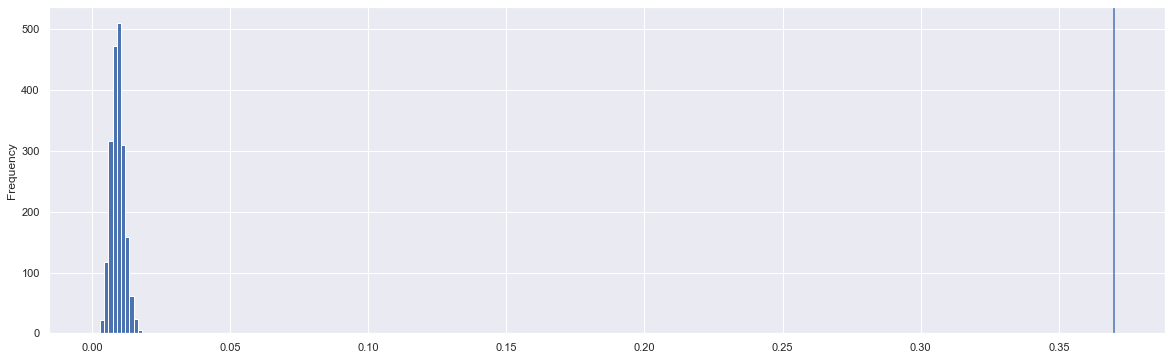

In [98]:
def permutation(cleaned, N):
    obs = calculateTVD(age_probabilities, 'mos_age_incident', 'complainant_age_incident')
    tvds = []
    for i in range(N):
        tvds.append(one_experiment(cleaned))
    
    # Plot distribution
    fig, ax = plt.subplots(figsize = (20, 6))
    pd.Series(tvds).plot(kind = 'hist')
    plt.axvline(obs)

    p_value = np.mean(np.array(tvds) >= obs)
    return p_value

print("P-value: {}".format(permutation(cleaned, 2000)))

With a p-value of 0, we can reject the null hypothesis with high confidence in favor of the alternative: that the distribution of police officer ages and complainant ages are not the same.